# Trying things out with PyMC3 Part 2 Copy 1

## Generating observations

For our test problem, we'll do a three-parameter model which fits a straight line to data. The parameters will be the slope, the intercept, and the scatter about the line; the scatter in this case will be treated as a nuisance parameter.

$\hat{y} = f(x | \alpha, \beta) = \alpha x_i + \beta$


with Gaussian noise on the observed values,

$ P(x_i, y_i | \alpha, \beta, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp [\frac{-(y_i - \hat{y_i})^2}{2\sigma^2}] $

$ \forall i$, likelihood function becomes:

$ P(x, y | \alpha, \beta, \sigma) = (2\pi\sigma^2) ^ {-N/2} \exp [\frac{1}{2\sigma^2} \sum_{i=1}^{N} -(y_i - \hat{y_i})^2] $

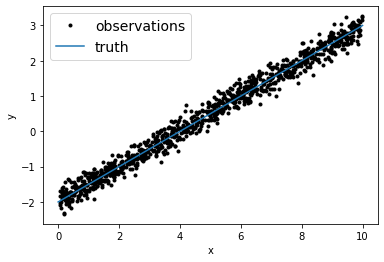

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# slope, intercept, variance
true_params = np.array([0.5, -2, 0.2])

N = 1000
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, N) # we are limiting the data generation from 0 to 10
y = x * true_params[0] + true_params[1]
y_obs = y + true_params[-1] * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

## Defining the model in PyMC3

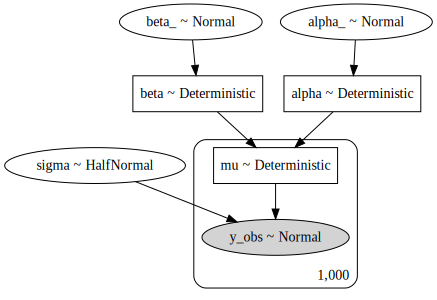

In [11]:
import pymc3 as pm
import theano

x_shared = theano.shared(x)

with pm.Model() as lineFittingModel:
    
    alpha_ = pm.Normal('alpha_', mu=0, sigma=10)
    beta_ = pm.Normal('beta_', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    alpha = pm.Deterministic("alpha", alpha_)
    beta = pm.Deterministic("beta", beta_)
    mu_calc = alpha * x_shared + beta
    mu = pm.Deterministic("mu", mu_calc)
#     mu = 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('y_obs', mu = mu , sigma=sigma, observed=y_obs)
pm.model_to_graphviz(lineFittingModel)

## MAP Estimate

In [ ]:
map_estimate = pm.find_MAP(model=lineFittingModel)

map_estimate

## NUTS Sampler

In [ ]:
with lineFittingModel:
    trace = pm.sample(draws=2000, tune = 2000)

In [ ]:
pm.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'], ref_val=list(true_params), kind="%hist")

In [ ]:
import corner
samples = np.vstack([trace[k] for k in ["alpha", "beta", "sigma"]]).T
corner.corner(samples, truths=true_params);

In [ ]:
pm.plot_trace(trace, var_names=['alpha', 'beta', 'sigma'])

## MCMC

In [ ]:
import theano

f = theano.function(lineFittingModel.vars, [lineFittingModel.logpt] + lineFittingModel.deterministics)
    
def log_prob_func(params):
    dct = lineFittingModel.bijection.rmap(params)
    args = (dct[k.name] for k in lineFittingModel.vars)
    results = f(*args)
    return tuple(results)

In [ ]:
[lineFittingModel.logpt] + lineFittingModel.deterministics

In [ ]:
with lineFittingModel:
    res = pm.find_MAP()

In [ ]:
vec = lineFittingModel.bijection.map(res)

In [ ]:
dct = lineFittingModel.bijection.rmap(vec)

In [ ]:
args = (dct[k.name] for k in lineFittingModel.vars)

In [ ]:
lineFittingModel.observed_RVs

In [ ]:
f2 = theano.function(lineFittingModel.vars, lineFittingModel.)

In [ ]:
import emcee

with lineFittingModel:
    # First we work out the shapes of all of the deterministic variables
    res = pm.find_MAP()
    vec = lineFittingModel.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(lineFittingModel.deterministics, initial_blobs)]
    
    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(25, len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(coords, 5000, progress=True)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["alpha", "beta", "sigma"]], truths=true_params);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta", "logs"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = .3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

## APT

In [41]:
def linearFittingSimulator(x, params, seed=None):
    
    alpha = params[0,0] 
    beta = params[0, 1]
    sigma = params[0, 2]
    np.random.seed(123)
    results = lineFittingModel.y_obs.distribution.random({mu: lineFittingModel.mu.eval({beta_: params[0, 1], alpha_: params[0, 0]}), sigma: params[0, 2]}, 1).reshape(-1, 1)

    return results

In [42]:
from delfi.simulator.BaseSimulator import BaseSimulator

class linearFittingSNPE(BaseSimulator):
    def __init__(self, x, seed = None):
        """Hodgkin-Huxley simulator

        Parameters
        ----------
        I : array
            Numpy array with the input current
        dt : float
            Timestep
        V0 : float
            Voltage at first time step
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 3

        super().__init__(dim_param=dim_param, seed=seed)
        self.x = x
        self.linearFittingSimulator = linearFittingSimulator
        
    def gen_single(self, params):

        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.gen_newseed()

        states = self.linearFittingSimulator(x, params.reshape(1, -1), seed=hh_seed)

        return {'data': states.reshape(-1)}

In [43]:
m = linearFittingSNPE(x = x_shared)

In [44]:
import delfi.generator as dg

In [45]:
import delfi.distribution as dd

seed_p = 2
prior_min = np.array([.5,1e-4])
prior_max = np.array([80.,15.])
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)

In [46]:
g = dg.Default(model=m, prior=prior, summary=s)

NameError: name 's' is not defined

In [52]:
m.gen_single(true_params)

{'data': array([-3.11140161e+01, -9.34027316e+01, -6.90267270e+01, -5.57054407e+01,
        -7.08577966e+00, -6.60355532e+00,  3.42245088e+00, -8.42533889e+01,
        -5.53122314e+01, -6.64750403e+01,  7.55794324e+00, -9.54485647e+01,
        -8.05219782e+01, -1.24544984e+01, -9.14720698e+00, -9.65337474e+00,
        -2.29467321e+01, -4.67870502e+01, -3.64979735e+01, -2.19080931e+01,
        -5.61184339e+01, -5.52524721e+00, -2.19231326e+01, -2.95432172e+01,
        -3.99431847e+01, -7.53072872e+01, -1.19476005e+01, -4.59257447e+01,
        -5.51328247e+01,  4.42934973e+00, -5.61815242e+01, -8.27671434e+00,
         2.86211929e+00, -9.30396580e+01, -9.46637620e+01, -7.80375255e+01,
        -2.30160881e+01, -8.58030547e-01, -6.47978702e+01, -3.79214635e+01,
        -3.11301507e+00, -4.36886529e+01,  6.23678360e+00, -8.80681633e+01,
        -1.80036470e+01, -6.16750310e+01, -2.32335075e+01, -4.68529198e+01,
        -4.96730413e+01, -9.60147788e+00, -9.55134546e+01, -7.41689373e+01,
    

In [33]:
obs

{'data': array([12.50587723, 30.55763104, 23.09548223, 19.3480984 ,  5.85097739,
         6.11931613,  3.05488726, 27.0435006 , 19.793958  , 22.792756  ,
         2.04623905, 29.58979089, 26.0541589 ,  8.48118284,  6.7378798 ,
         7.16480328, 10.85574864, 17.06685953, 14.00392127,  9.36427285,
        19.79015474,  5.31231838, 10.13534681, 11.93685757, 14.8857799 ,
        24.76058775,  7.41102065, 16.37395861, 19.35798781,  2.60668379,
        18.99018111,  6.43636966,  3.33980736, 29.66646377, 30.5068523 ,
        25.37438209, 10.42200959,  3.98612506, 21.982038  , 14.54034244,
         4.90551294, 15.58209029,  2.82932792, 28.09412073,  8.92428261,
        21.20457161, 10.32637573, 16.43962134, 17.05255545,  7.09906311,
        30.08115219, 25.28603272, 29.05827732, 27.75023276, 19.01918868,
        28.88649196,  3.89336282,  7.39913926,  2.46158006, 10.67879242,
        12.44445444,  8.83322591, 25.89920887, 11.92130535,  9.57185698,
        17.89229497,  5.93672726, 25.161929

In [31]:
y

array([-0.12729941,  2.75357153,  1.65996971,  0.99329242, -1.2199068 ,
       -1.2200274 , -1.70958194,  2.33088073,  1.00557506,  1.54036289,
       -1.89707753,  2.84954926,  2.1622132 , -0.93830445, -1.09087516,
       -1.08297745, -0.47878879,  0.62378216,  0.15972509, -0.5438543 ,
        1.05926447, -1.3025307 , -0.53927676, -0.16819078,  0.28034992,
        1.92587981, -1.00163109,  0.57117219,  0.96207284, -1.76774794,
        1.03772426, -1.14737938, -1.67474204,  2.74442769,  2.82816017,
        2.04198674, -0.47693115, -1.51163943,  1.42116513,  0.20076247,
       -1.38980883,  0.47588455, -1.82805739,  2.54660201, -0.70610009,
        1.31261142, -0.44144462,  0.60034011,  0.7335514 , -1.07572772,
        2.84792314,  1.87566412,  2.69749471,  2.47413675,  0.98949989,
        2.60937118, -1.55753749, -1.02008569, -1.77386356, -0.37334835,
       -0.05661355, -0.64325484,  2.14368755, -0.21623337, -0.59532745,
        0.71348042, -1.29537888,  2.0109849 , -1.62724678,  2.93

## VBMC